# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
import fastai

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [4]:
bs = 64 #(hoeveel images train je tegelijkertijd; lager zitten bij out of memory error)
bs = 32   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [5]:
#help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [7]:
import os
os.getcwd()

'C:\\Users\\wille\\OneDrive\\Documenten\\Onedrive Rox\\OneDrive\\Willem\\Python\\FastAI\\course-v3\\nbs\\dl1'

In [30]:
path = Path('C:\\Users\wille\\OneDrive\\Documenten\\Onedrive Rox\\OneDrive\\Willem\\Python\\FastAI\\beer challenge')
path



WindowsPath('C:/Users/wille/OneDrive/Documenten/Onedrive Rox/OneDrive/Willem/Python/FastAI/beer challenge')

In [31]:
path.ls()

[WindowsPath('C:/Users/wille/OneDrive/Documenten/Onedrive Rox/OneDrive/Willem/Python/FastAI/beer challenge/.ipynb_checkpoints'),
 WindowsPath('C:/Users/wille/OneDrive/Documenten/Onedrive Rox/OneDrive/Willem/Python/FastAI/beer challenge/afbeeldingen'),
 WindowsPath('C:/Users/wille/OneDrive/Documenten/Onedrive Rox/OneDrive/Willem/Python/FastAI/beer challenge/beerchallenge.ipynb'),
 WindowsPath('C:/Users/wille/OneDrive/Documenten/Onedrive Rox/OneDrive/Willem/Python/FastAI/beer challenge/models')]

In [32]:
#path_anno = path/'annotations'
path_img = path/'afbeeldingen'
path_img

WindowsPath('C:/Users/wille/OneDrive/Documenten/Onedrive Rox/OneDrive/Willem/Python/FastAI/beer challenge/afbeeldingen')

In [36]:
path_img.ls()

[WindowsPath('C:/Users/wille/OneDrive/Documenten/Onedrive Rox/OneDrive/Willem/Python/FastAI/beer challenge/afbeeldingen/train'),
 WindowsPath('C:/Users/wille/OneDrive/Documenten/Onedrive Rox/OneDrive/Willem/Python/FastAI/beer challenge/afbeeldingen/valid')]

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [37]:
data = ImageDataBunch.from_folder(path_img, #path naar image files--> moeten folders train and valid bevatten
                                   #fnames, #filesnames waar hij naar moet kijken
                                   #pat, #de regular expression pattern
                                   ds_tfms=get_transforms(), 
                                   size=224, #alle images moeten zelfde afmeting hebben, dit is vrijwel altijd 224x224
                                   bs=bs #batchsize (hoeveel images train je tegelijkertijd; lager zitten bij out of memory error)
                                  ).normalize(imagenet_stats) #normaliseer zodat alle pixels mean=0 en sd=1 hebben ipv van 0-255 lopen

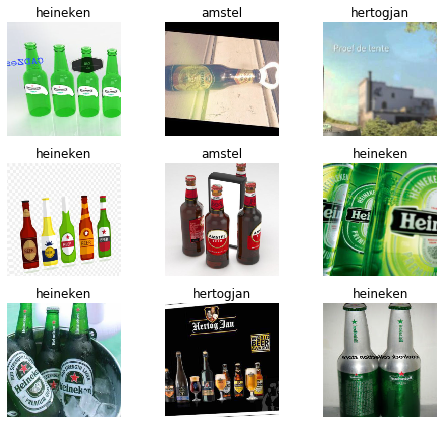

In [38]:
data.show_batch(rows=3, #3x3
                figsize=(7,6)) #afmetingen van afbeeldingen

In [39]:
print(data.classes) #data.classes is lijst van mogelijke labels
print(len(data.classes), 
      data.c) #voor nu: het aantal labels

['amstel', 'heineken', 'hertogjan']
3 3


## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [40]:
learn = cnn_learner(data, #creeer leaner (CNN) voor databunch
                    models.resnet34, #welk moodel moet worden geimporteerd
                    metrics=error_rate) #welke metrics moeten geprint worden

In [21]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [41]:
learn.fit_one_cycle(4) #fit one cycle (4 epochs). Hier wordt het originele model (resnet34 intact gelaten, en alleen 4 layers aan het eind toegevoegd)

epoch,train_loss,valid_loss,error_rate,time
0,1.120193,0.133628,0.050761,01:33
1,0.741060,0.206310,0.065990,01:08
2,0.509470,0.192905,0.055838,01:07
3,0.392306,0.179420,0.060914,01:07


In [42]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [56]:
interp = ClassificationInterpretation.from_learner(learn) #object om de resultaten van een classificatie learn object te bekijken

In [44]:
losses,idxs = interp.top_losses()

In [45]:
len(data.valid_ds)==len(losses)==len(idxs)

True

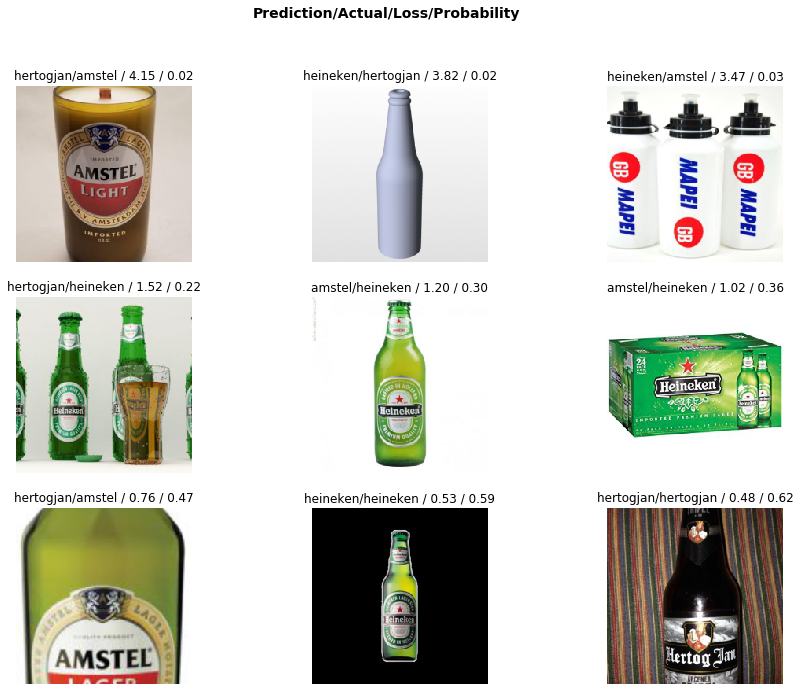

In [57]:
interp.plot_top_losses(9, #print images met grootste bijdrage aan loss 
                       figsize=(15,11))

In [26]:
doc(interp.plot_top_losses)

_cl_int_plot_top_losses [source] [test] _cl_int_plot_top_losses ( k , largest = True , figsize = (12, 12) , heatmap : bool = False , heatmap_thresh : int = 16 , alpha : float = 0.6 , cmap : str = 'magma' , show_text : bool = True , return_fig : bool = None ) → Optional [ Figure ] 
 
 × No tests found for _cl_int_plot_top_losses . To contribute a test please refer to this guide and this discussion . Show images in top_losses along with their prediction, actual, loss, and probability of actual class. 
 Show in docs

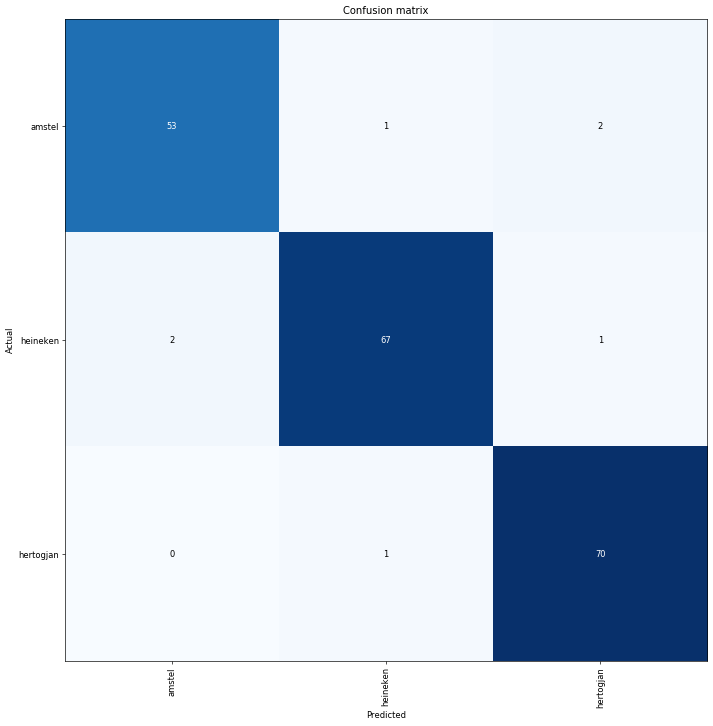

In [58]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [50]:
interp.most_confused(min_val=2)

[('amstel', 'hertogjan', 4), ('heineken', 'amstel', 4)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [51]:
learn.unfreeze() #met unfreeze geef je aan dat je het hele model wilt trainen, niet alleen de laatste x layers. 
#Dit is normaal gesproken een 2e stap om de performance te verbeteren

In [49]:
learn.load('stage-1'); #reload het model, omdat we het model hierboven slechter hebben gemaakt

In [52]:
learn.lr_find() #learning rate = hoe snel update ik de parameters in mijn model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


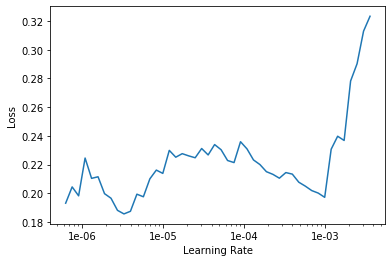

In [53]:
learn.recorder.plot() #wanneer de learning rate > 1e-02 (0.01) de loss neemt snel toe. We moeten hier dus de juiste learning rate meegeven, zodat niet alle parameters
#uit de eerste lagen volledig worden hertraind.

In [54]:
learn.unfreeze() #unfreeze model: dus adjust alle layers in plaats van alleen wat layers toe te voegen
learn.fit_one_cycle(2, #run 2 epochs 
                    max_lr=slice(1e-6,1e-4)) #waarbij de learrning rate varieert van .00001 tot 0.001 (learning rate op eerste layers is lager dan bij laatste layers)
#slice = seq() vergelijkbaar object in Python  

epoch,train_loss,valid_loss,error_rate,time
0,0.227489,0.130399,0.050761,01:09
1,0.243303,0.120169,0.040609,01:09


In [55]:
learn.fit_one_cycle(2, #run 2 epochs 
                    max_lr=slice(1e-6,1e-4)) #waarbij de learrning rate varieert van .00001 tot 0.001 (learning rate op eerste layers is lager dan bij laatste layers)

epoch,train_loss,valid_loss,error_rate,time
0,0.167237,0.116878,0.045685,01:36
1,0.163647,0.102157,0.035533,01:11


That's a pretty accurate model!